In [1]:
import pandas as pd
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


In [2]:
import pandas as pd

# Load the uploaded CSV file to examine its structure
file_path = './youtube_channel_video_text_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and the column names to understand its structure
data.head(), data.columns

(  채널구분                      채널ID              제목       개설 날짜        구독자  \
 0    A  UCMFk5S7g5DY-CZNVh_Kyz_A  약사가 들려주는 약 이야기  2017-03-02  1,780,000   
 1    A  UCMFk5S7g5DY-CZNVh_Kyz_A  약사가 들려주는 약 이야기  2017-03-02  1,780,000   
 2    A  UCMFk5S7g5DY-CZNVh_Kyz_A  약사가 들려주는 약 이야기  2017-03-02  1,780,000   
 3    B  UC3iSLVH0MxHfwO69oHKpvog            리틀약사  2015-02-16    454,000   
 4    B  UC3iSLVH0MxHfwO69oHKpvog            리틀약사  2015-02-16    454,000   
 
           영상ID                                            대표영상텍스트  
 0  j9SsD4vallY   안녕하십니까? 약대로 약의 껍약사입니다. 화이팅 먼저 외치고 시작하겠습니다. 화이...  
 1  9Kkm1Ra5zP0   이 맛은 너무 맛있는데요. 이런 게 바로 혈관 건강을 정말 망치는 혈관을 딱딱하게...  
 2  sbPNzlPe7H0   하루에 한잔 이 차를 마시면 당려 를 예방할 수가 있습니다. 약들약? 안녕하십니까...  
 3  sguIG5DqPKs  먹는 것이건 나를 만든다 안녕하세요. 시작합니다. 여러분 혹시 집에 이 바세린 이거...  
 4  CAG8I0cI5XU  먹는 것이 곤 나를 만든다 안녕하세요 리틀략사입니다 혹시 단식을 하면 해독이 된다 ...  ,
 Index(['채널구분', '채널ID', '제목', '개설 날짜', '구독자', '영상ID', '대표영상텍스트'], dtype='object'))

In [3]:
# 한국어 불용어 리스트
stop_words  = set([
    '이', '그', '저', '것', '수', '것을', '그리고', '더', '더욱', '너무', '정말', '진짜', '이제', '다시', '이런', '저런', '그런', '또', '또는',
    '하지만', '그러나', '그래도', '반면에', '이외에', '이렇게', '저렇게', '여기', '저기', '이것', '저것', '여러', '여러분', '너', '나', '우리',
    '당신', '어떤', '어느', '무엇', '누구', '모두', '많은', '좋은', '아주', '매우', '너무', '정말', '진짜', '자주', '항상', '가장', '크게', '작게',
    '게', '거'
])

In [4]:
# 추가 불용어 정의
custom_stop_words = set([
    '안녕하세요', '감사합니다', '잘', '다시', '정말', '이것', '그것', '그리고', '그러나', '하지만', 
    '해서', '하는', '같은', '이런', '저런', '그런', '할', '있는', '없는', '있는지', '없는지', '시청', '감사', '생각',
    '양과자', '선생'
])

In [5]:
# 확장된 영양제 및 관련 키워드 목록 정의
nutrient_keywords = set([
    # 영양제 및 건강보조식품
    '비타민', '칼슘', '오메가3', '프로바이오틱스', '철분', '마그네슘', '아연', '비타민A', '비타민B', '비타민C', '비타민D', '비타민E', '엽산',
    '멜라토닌', '베르베린', '유산균', '단백질', '아미노산', '콜라겐', '코엔자임Q10', '글루타민', '알로에', '홍삼', '녹용', '스피루리나', '클로렐라', 
    '히알루론산', '글루코사민', '로얄젤리', '프로폴리스', '오메가-3', '유산균', '밀크씨슬', '루테인', 'EPA', 'DHA', '크릴오일', '코큐텐', 
    '아르기닌', '타우린', '피쉬오일', '피부영양제', '머리영양제', '헤어영양제', '비오틴', '피쉬콜라겐',
    
    # 질병
    '면역', '피로', '피곤', '수면', '스트레스', '소화', '혈압', '당뇨', '콜레스테롤', '간', '간건강', '심장', '장', '장건강', 
    '알레르기', '감기', '독감', '빈혈', '치매', '우울증', '불안증', '폐렴', '천식', '관절염', '골다공증', '비만', '다이어트', '체중감량', 
    '피부질환', '아토피', '습진', '건선', '백반증', '자가면역질환', '천식', '기관지염', '천식',
    
    # 신체 부위
    '관절', '뼈', '눈', '피부', '탈모', '간', '심장', '장', '위', '신장', '폐', '두뇌', '척추', '근육', '대장', '소장', '방광', 
    '전립선', '갑상선', '귀', '코', '목', '발', '팔', '다리', '발목', '손목', '발가락', '손가락', '이마', '턱', '목', '등', 
    '허리', '배', '속', '가슴', '폐', '갈비뼈', '갈비뼈', '어깨', '목', '머리', '머릿결', '피부결',
    
    # 증상
    '소화불량', '변비', '설사', '복통', '두통', '어지럼증', '피부건조', '여드름', '탈모', '부종', '수족냉증', '불면증', '과민성대장증후군', 
    '속쓰림', '메스꺼움', '구토', '기침', '가래', '가슴답답함', '숨가쁨', '피로감', '무기력', '무기력증', '피부염', '소양증', '소화장애', 
    '식욕부진', '구역질', '경련', '발작', '호흡곤란', '가래', '가슴통증', '흉통', '수면장애', '피부발진', '진드기', '벌레물림', '가려움증', 
    '아픔', '통증', '피부붉어짐', '화끈거림', '발열', '오한', '근육통', '관절통', '허리통증', '요통', '등통증', '목통증', '어깨통증', 
    '팔통증', '다리통증', '발통증', '발목통증', '손목통증', '발가락통증', '손가락통증', '이마통증', '턱통증', '목통증', '속쓰림',
    
    # 추가 키워드
    '항산화', '항염', '항바이러스', '항균', '항진균', '디톡스', '해독', '활력', '에너지', '체력증강', '근력증가', '신진대사', '대사증후군',
    '면역력', '면역강화', '피로회복', '혈액순환', '혈류', '혈관', '심혈관', '폐활량', '근력강화', '유산소운동', '근력운동', '헬스', 
    '피트니스', '근육량', '근지구력', '체지방', '근비대', '근육성장', '근육회복', '운동', '운동효과', '운동방법', '운동계획', '운동프로그램', 
    '운동루틴', '운동기구', '운동기법', '운동습관', '운동요법', '운동처방', '운동능력', '운동자세', '운동부위', '운동종목', '운동시간', 
    '운동강도', '운동빈도', '운동량', '운동지속시간', '운동지속', '운동패턴', '운동기록', '운동성향', '운동습관', '운동계획', '운동법', 
    '운동기법', '운동량', '운동기구', '운동용품', '운동복', '운동화', '운동신발', '운동모자', '운동장갑', '운동양말', '운동용품', '운동기구', 
    '운동용품', '운동복', '운동화', '운동신발', '운동모자', '운동장갑', '운동양말'
])


In [6]:
# Mecab 형태소 분석기 설정
mecab = Mecab()

# 채널별로 대표 텍스트에서 명사를 추출
def extract_nouns(text):
    tokens = mecab.morphs(text)
    tokens = [word for word in tokens if word not in stop_words and word not in custom_stop_words]
    return tokens


In [7]:
grouped_data = data.groupby('채널ID')['대표영상텍스트'].apply(' '.join).reset_index()
grouped_data['nouns'] = grouped_data['대표영상텍스트'].apply(extract_nouns)
grouped_data['nouns_str'] = grouped_data['nouns'].apply(' '.join)

In [8]:
grouped_data

,채널ID,대표영상텍스트,nouns,nouns_str
0,UC3iSLVH0MxHfwO69oHKpvog,먹는 것이건 나를 만든다 안녕하세요. 시작합니다. 여러분 혹시 집에 이 바세린 이거...,"[먹, 는, 건, 를, 만든다, 안녕, 하, 세요, ., 시작, 합니다, ., 혹시...",먹 는 건 를 만든다 안녕 하 세요 . 시작 합니다 . 혹시 집 에 바세린 이거 하...
1,UC6ggXTuBVchhwHeQ12Ita1w,"제가 예전에 크로세틴에 관한 영상을 제작할 때, ""야, 이거 정말 물건이네!"" 이런...","[제, 가, 예전, 에, 크로세, 틴, 에, 관한, 영상, 을, 제작, 때, ,, ...","제 가 예전 에 크로세 틴 에 관한 영상 을 제작 때 , "" 야 , 이거 물건 네 ..."
2,UCCMFTDGarjgZLc1DlIbbvRg,"안녕하세요, 여러분. 시작됩니다. 날씨가 추워지고 건조해지면서 저녁에 씻고 나오면 ...","[안녕, 하, 세요, ,, ., 시작, 됩니다, ., 날씨, 가, 추워, 지, 고,...","안녕 하 세요 , . 시작 됩니다 . 날씨 가 추워 지 고 건조 해 지 면서 저녁 ..."
3,UCMFk5S7g5DY-CZNVh_Kyz_A,안녕하십니까? 약대로 약의 껍약사입니다. 화이팅 먼저 외치고 시작하겠습니다. 화이...,"[안녕, 하, 십니까, ?, 약대, 로, 약, 의, 껍, 약사, 입니다, ., 화이...",안녕 하 십니까 ? 약대 로 약 의 껍 약사 입니다 . 화이팅 먼저 외치 고 시작 ...
4,UCY-mXLM6DsS9cmSwlh0tqSA,먼저 분말을 그대로 이용하시는 분들을 위한 제품을 먼저 추천 드리자면 1등은 안녕...,"[먼저, 분말, 을, 그대로, 이용, 하, 시, 는, 분, 들, 을, 위한, 제품,...",먼저 분말 을 그대로 이용 하 시 는 분 들 을 위한 제품 을 먼저 추천 드리 자면...


In [9]:
# TF-IDF 벡터라이저를 사용하여 각 채널의 명사에 대해 TF-IDF 계산
tfidf_vectorizer = TfidfVectorizer(vocabulary=nutrient_keywords)
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_data['nouns_str'])

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped_data['채널ID'], columns=tfidf_vectorizer.get_feature_names_out())

# 각 채널별로 TF-IDF 값이 높은 상위 10개의 단어를 추출
top_n = 90
top_keywords = {}

for channel_id in grouped_data['채널ID']:
    sorted_indices = np.argsort(tfidf_df.loc[channel_id])[::-1]
    top_keywords[channel_id] = tfidf_df.columns[sorted_indices][:top_n]

# 키워드 결과를 데이터프레임으로 변환
top_keywords_df = pd.DataFrame(top_keywords).T
top_keywords_df.columns = [f'Keyword_{i+1}' for i in range(top_n)]

/home/arkwith/aSSIST/aSSIST_DM1/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [10]:
top_keywords_df

,Keyword_1,Keyword_2,Keyword_3,Keyword_4,Keyword_5,Keyword_6,Keyword_7,Keyword_8,Keyword_9,Keyword_10,...,Keyword_81,Keyword_82,Keyword_83,Keyword_84,Keyword_85,Keyword_86,Keyword_87,Keyword_88,Keyword_89,Keyword_90
UC3iSLVH0MxHfwO69oHKpvog,마그네슘,대장,에너지,가려움증,복통,피부,해독,근육,심장,스트레스,...,장건강,운동장갑,운동종목,운동자세,운동용품,운동신발,운동시간,운동요법,운동양말,운동빈도
UC6ggXTuBVchhwHeQ12Ita1w,베르베린,전립선,당뇨,혈압,단백질,에너지,콜레스테롤,다이어트,운동,해독,...,코큐텐,운동장갑,운동종목,운동지속,운동자세,운동신발,운동용품,운동요법,운동양말,운동빈도
UCCMFTDGarjgZLc1DlIbbvRg,콜레스테롤,관절,단백질,운동,콜라겐,관절염,소화,피부,통증,근육,...,장건강,운동장갑,운동종목,운동지속,운동자세,운동신발,운동용품,피부질환,항바이러스,피부영양제
UCMFk5S7g5DY-CZNVh_Kyz_A,비타민,혈관,신장,마그네슘,피부,여드름,아연,체지방,유산균,철분,...,콜라겐,운동장갑,운동종목,운동자세,운동용품,운동신발,운동시간,운동요법,운동양말,운동빈도
UCY-mXLM6DsS9cmSwlh0tqSA,콜라겐,알레르기,유산균,비타민,대장,비오틴,히알루론산,에너지,운동,칼슘,...,체지방,운동장갑,운동종목,운동지속,운동자세,운동신발,운동용품,운동요법,운동양말,운동빈도


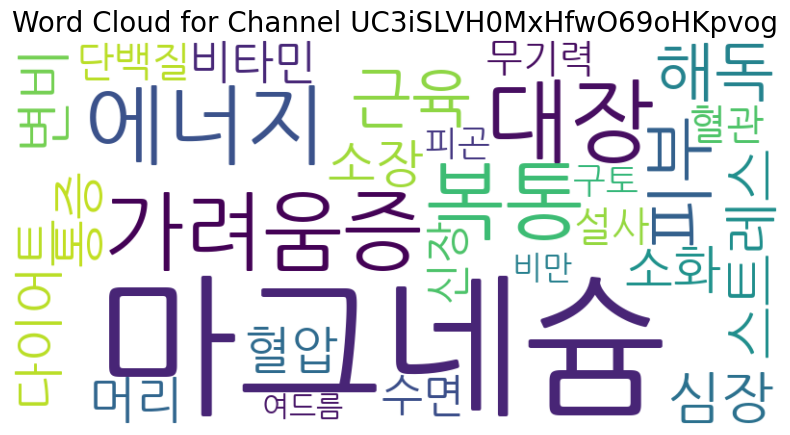

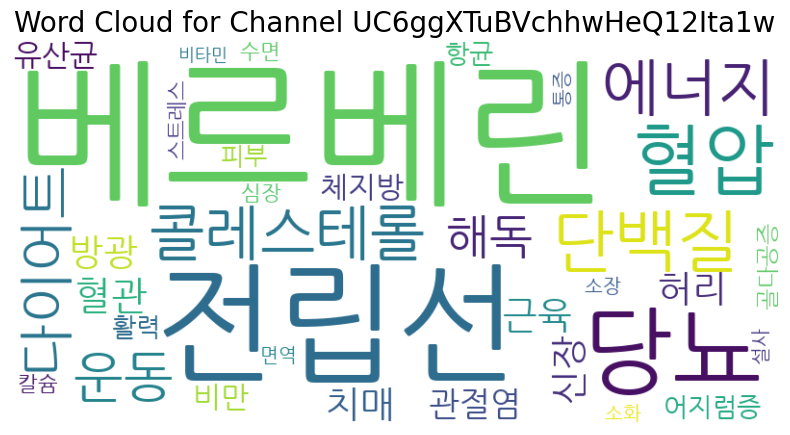

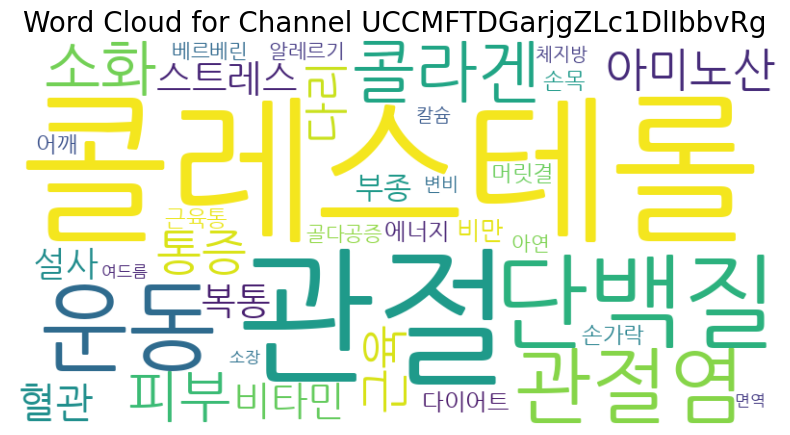

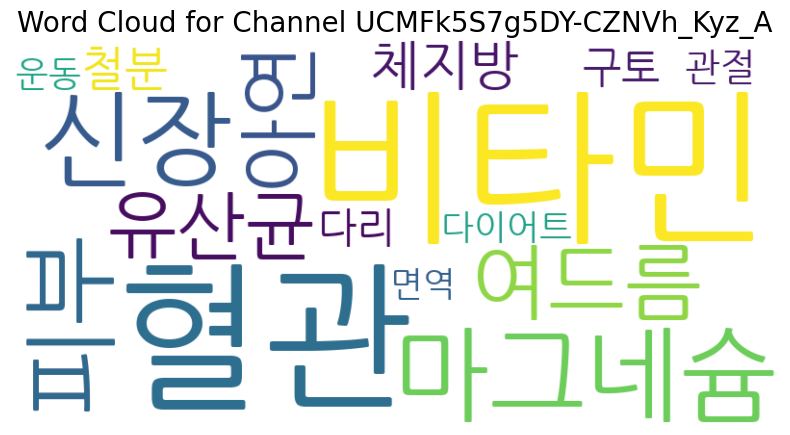

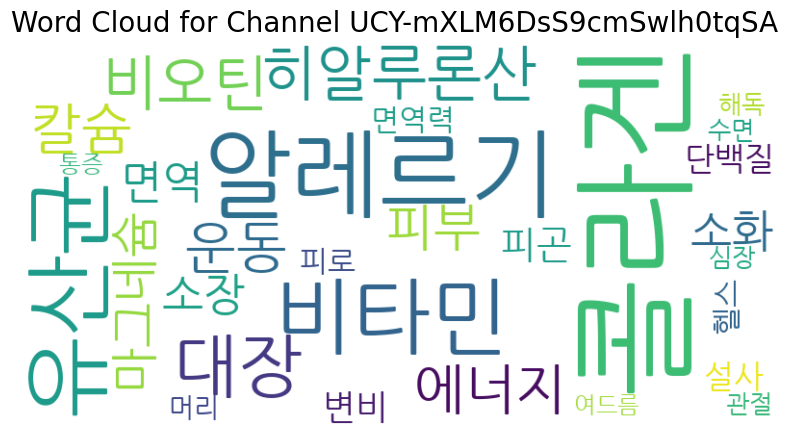

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 각 채널별로 워드 클라우드를 생성
for channel_id in grouped_data['채널ID']:
    # 해당 채널의 TF-IDF 값을 가져옴
    channel_tfidf = tfidf_df.loc[channel_id]
    
    # TF-IDF 값을 딕셔너리 형태로 변환
    tfidf_dict = channel_tfidf.to_dict()
    
    # 워드 클라우드 생성
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        colormap='viridis'
    ).generate_from_frequencies(tfidf_dict)
    
    # 워드 클라우드 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Channel {channel_id}", fontsize=20)
    plt.axis('off')
    plt.show()